In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_add_pool, global_max_pool
import torch.nn.functional as F
import numpy as np

from gfn import ConditionalFlowModel, ContrastiveScorer

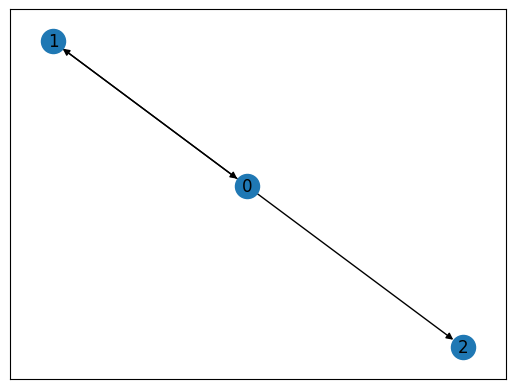

In [2]:
def is_cycle(edges, edge):
    # check if adding edge creates a cycle
    # edges is a list of edges, edge is a new edge
    # returns True if cycle is created
    if len(edges) == 0:
        return False
    edges = edges + [edge]
    num_nodes = max([max(edge) for edge in edges]) + 1
    adj = torch.zeros((num_nodes, num_nodes))
    for edge in edges:
        adj[edge[0], edge[1]] = 1
    return (torch.trace(torch.matrix_power(adj, 5*num_nodes)) > 0).item()

# generate a random DAG
def generate_dag(num_steps, num_features):
    graph_node_features = []
    graph_edge_indices = []

    for i in range(num_steps):
        node_features = torch.randn(num_features)
        
        
        if i == 0:
            graph_node_features.append(node_features)
            continue

        # generate a random edge from one of the existing nodes to either a new node or an existing node
        # if the edge creates a cycle, try again, with timeout
        k = 0
        while True:
            k += 1
            if k > 100:
                raise ValueError('Cannot generate a DAG with given parameters.')
            source = torch.randint(len(graph_node_features), (1, ))
            target = torch.randint(len(graph_node_features) + 1, (1, ))
            edge = torch.cat([source, target])
            if not is_cycle(graph_edge_indices, edge):
                # if new node, add feature
                if target == len(graph_node_features):
                    graph_node_features.append(node_features)
                graph_edge_indices.append(edge)
                break
        

    graph_node_features = torch.stack(graph_node_features)
    graph_edge_indices = torch.stack(graph_edge_indices).T
    return graph_node_features, graph_edge_indices

def visualize_dag(graph_node_features, graph_edge_indices):
    # visualize the DAG
    import networkx as nx
    import matplotlib.pyplot as plt
    G = nx.DiGraph()
    for i in range(graph_node_features.shape[0]):
        G.add_node(i)
    for edge in graph_edge_indices.T:
        G.add_edge(edge[0].item(), edge[1].item())
    nx.draw_networkx(G, with_labels=True)
    plt.show()

while True:
    try:
        graph_node_features, graph_edge_indices = generate_dag(10, 5)
        break
    except ValueError:
        pass
visualize_dag(graph_node_features, graph_edge_indices)


In [3]:
# test the DAG scorer
net_config = {
    'num_node_features': 5,
    'hidden_dim': 7,
    'num_heads': 2,
    'dropout': 0.1,
    'num_gat_layers': 2,
    'graph_embedding_dim': 10,
    'num_contrastive_layers': 2,
}
scorer = ContrastiveScorer(net_config)

# Random minibatch of graph pairs
graph_pairs = []
while len(graph_pairs) < 10:
    try:
        graph1_node_features, graph1_edge_indices = generate_dag(10, 5)
        graph2_node_features, graph2_edge_indices = generate_dag(10, 5)
        graph_pairs.append([graph1_node_features, graph1_edge_indices, graph2_node_features, graph2_edge_indices])
    except ValueError:
        pass

graph1s = [graph_pair[0] for graph_pair in graph_pairs]
graph1_edge_indices = [graph_pair[1] for graph_pair in graph_pairs]
graph2s = [graph_pair[2] for graph_pair in graph_pairs]
graph2_edge_indices = [graph_pair[3] for graph_pair in graph_pairs]

tensor([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5,
        5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9])


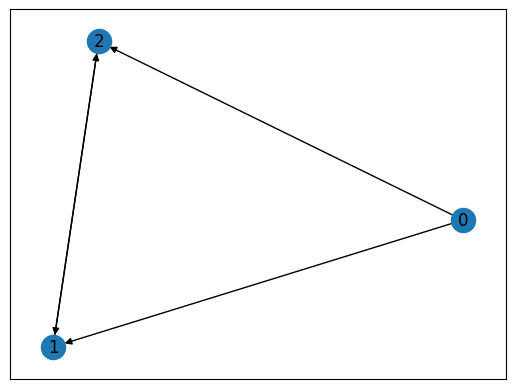

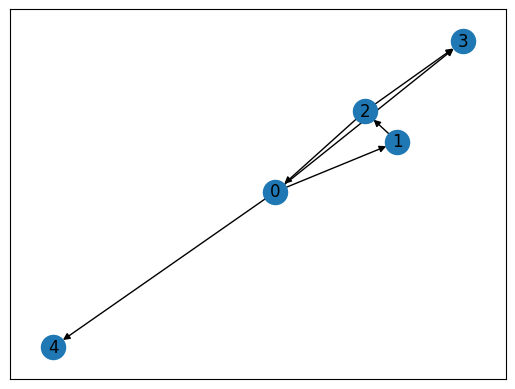

In [4]:
from torch_geometric.data import Data, Batch

graph_batch_1 = Batch.from_data_list([Data(x=graph1s[i], edge_index=graph1_edge_indices[i]) for i in range(len(graph_pairs))])
graph_batch_2 = Batch.from_data_list([Data(x=graph1s[i], edge_index=graph1_edge_indices[i]) for i in range(len(graph_pairs))])

graph_data_1 = Data(x=graph1s[0], edge_index=graph1_edge_indices[0])
graph_data_2 = Data(x=graph2s[0], edge_index=graph2_edge_indices[0])
print(graph_batch_1.batch)
visualize_dag(graph_data_1.x, graph_data_1.edge_index)
visualize_dag(graph_data_2.x, graph_data_2.edge_index)


In [5]:
# test one optimization step of the scorer
# generate random pari assignments, 0 or 1
pair_assignments = torch.randint(2, (len(graph_pairs), )).view(-1, 1)
optimizer = torch.optim.Adam(scorer.parameters(), lr=0.001)
optimizer.zero_grad()
print(graph_data_1.edge_index.T.shape)
predicted_scores = scorer(graph_batch_1, graph_batch_2)

loss = F.binary_cross_entropy_with_logits(predicted_scores, pair_assignments.float())
loss.backward()
optimizer.step()

torch.Size([9, 2])


In [6]:
def get_mask(adj):
    # returns a mask over possible edges that can be added to the graph without creating a cycle
    num_nodes = adj.shape[0]
    mask = torch.ones((num_nodes, num_nodes))
    for i in range(num_nodes):
        mask[i, i] = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj[i, j] == 1:
                mask[j, :] = 0
                mask[:, i] = 0
    return mask


tensor([[[0.0000, 0.0833, 0.0833, 0.0833],
         [0.0833, 0.0000, 0.0833, 0.0833],
         [0.0833, 0.0833, 0.0000, 0.0833],
         [0.0833, 0.0833, 0.0833, 0.0000]]], grad_fn=<ViewBackward0>)
tensor([[3],
        [1]])
tensor([[[0.0000, 0.1371, 0.1371, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.1371, 0.1371, 0.0000, 0.0000],
         [0.1371, 0.1774, 0.1371, 0.0000]]], grad_fn=<ViewBackward0>)
tensor([[3],
        [2]])
tensor([[[0.0000, 0.1817, 0.1817, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.1817, 0.2355, 0.2193, 0.0000]]], grad_fn=<ViewBackward0>)
tensor([[0],
        [1]])
tensor([[[0.0000, 0.2424, 0.2157, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2818, 0.2601, 0.0000]]], grad_fn=<ViewBackward0>)
tensor([[3],
        [1]])
tensor([[[0.0000, 0.2595, 0.2303, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [

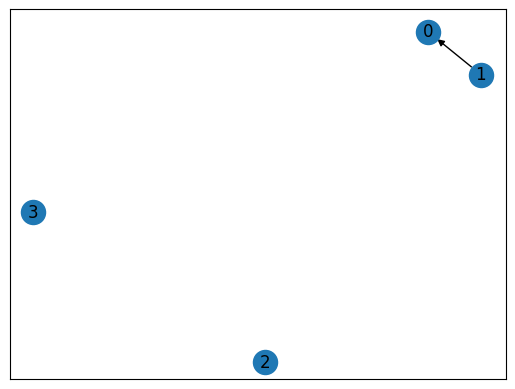

In [19]:
net_config_gfn = {
    'obs_type': 'image',
    'obs_channels': 3,
    'num_conv_layers': 5,
    'obs_size': 200,
    'max_nodes': 4,
    'embedding_dim': 10,
    'dropout': 0.1,
    'num_heads': 2,
    'num_transformer_blocks': 4,
    'num_tb_stop_heads': 4,
    'num_tb_transition_heads': 4,
    'num_variables' : 10
}

# test the conditional flow model
gflownet = ConditionalFlowModel(net_config_gfn)
# random observation, image of size N x N x 3
observation = torch.randn(1, net_config_gfn['obs_size'], net_config_gfn['obs_size'], 3)
# initialize adjacency matrix at 0
adj = torch.zeros((1, net_config_gfn['max_nodes'], net_config_gfn['max_nodes']))
# initialize node embeddings, of size (B=1, max_nodes, embedding_dim)
node_embeddings = torch.randn(1, net_config_gfn['max_nodes'], net_config_gfn['embedding_dim'])
MAX_ITER = 100
# generate random DAG
stop = 0
for _ in range(MAX_ITER):
    # reshape observation to be B x C x N x N
    observation = observation.view(1, 3, net_config_gfn['obs_size'], net_config_gfn['obs_size'])
    # gflownet is forward takes arguments: adj, node_embeddings, obs, mask
    transition_probs, stop_prob = gflownet(adj, node_embeddings, observation, get_mask(adj[0]))
    stop = torch.bernoulli(stop_prob).item()
    if stop:
        print('stopping')
        break

    transition_probs = transition_probs.view(net_config_gfn['max_nodes'], net_config_gfn['max_nodes'])
    # sample an edge to add

    edge = torch.multinomial(transition_probs.view(-1), 1)
    edge = torch.tensor(np.unravel_index(edge, (net_config_gfn['max_nodes'], net_config_gfn['max_nodes'])))
    # toggle the edge in the adjacency matrix
    adj[0, edge[0], edge[1]] = 1 - adj[0, edge[0], edge[1]]
    
# visualize the DAG
visualize_dag(node_embeddings[0], adj[0].long())

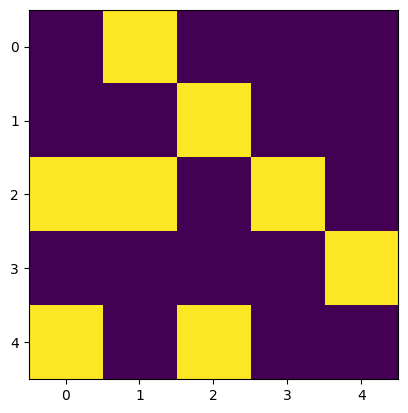

In [ ]:
from matplotlib import pyplot as plt
adjacency = torch.tensor([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 0, 0, 1], [1, 0, 1, 0, 0]])
plt.imshow(adjacency)
plt.show()

indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
sources [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]
targets [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]
edges [[0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [2 9]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 5]
 [4 6]
 [4 7]
 [4 8]
 [4 9]]


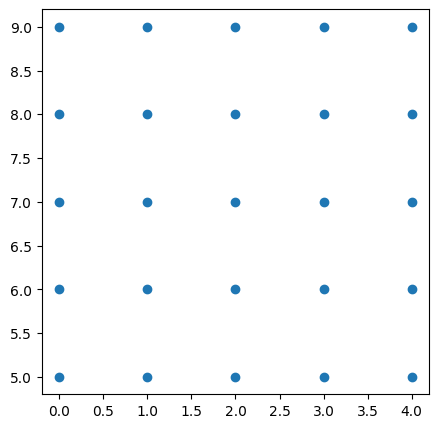

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4] [5 6 7 8 9 5 6 7 8 9 5 6 7 8 9 5 6 7 8 9 5 6 7 8 9]


In [ ]:
num_variables = adjacency.shape[0]
indices = np.arange(num_variables ** 2)
sources, targets = np.divmod(indices, num_variables)
edges = np.stack((sources, num_variables + targets), axis=1)
print("indices", indices)
print("sources", sources)
print("targets", targets)
print("edges", edges)
def visualize_process(edges):
    plt.figure(figsize=(5, 5))
    plt.scatter(edges[:, 0], edges[:, 1])
    plt.show()
visualize_process(edges)
print(edges[:, 0], edges[:, 1])

Nocturne get_episodes

In [2]:
import nocturne as nc

import nocturne.examples.imitation_learning.WaymoDataset as Dataset_nc

dataset = Dataset_nc(data_path='dataset/tf_records',
                        file_limit=20,
                        dataloader_config={
                            'view_dist': 80,
                            'n_stacked_states': 3,
                        },
                        scenario_config={
                            'start_time': 0,
                            'allow_non_vehicles': True,
                            'spawn_invalid_objects': True,
                        })

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    num_workers=4,
    pin_memory=True,
)

for i, x in zip(range(100), data_loader):
    print(i, x[0].shape, x[1].shape)


ModuleNotFoundError: No module named 'nocturne.examples'

In [ ]:


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        [...]

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            [...]

In [ ]:
from nocturne.envs.wrappers import create_env
import pickle
import random
import hydra
import numpy as np
import nocturne

@hydra.main(config_path="/home/jeremy/Documents/GitHub/GFlow-Net-for-Latent-Graph-Representation/", config_name="env_config")
def generate_contrastive_dataset(cfg):

    env = create_env(cfg)
    episodes = []
    for _ in range(cfg.number_of_episodes):
        env.reset()
        env.make_all_vehicles_experts()
        observations = []
        for _ in range(cfg.episode_length):
            action = env.action_space.sample()
            state, reward, done, info = env.step({})
            obs = env.get_observation(env.expert_controlled_vehicles[0])
            observations.append(obs)
            if done:
                break
        episodes.append(observations)

    with open(f"data/contrastive_dataset_{cfg.number_of_episodes}_{cfg.episode_length}.pkl", "wb") as f:
        # create a dataset of pairs of observations with labels 0 if they are from the same episode and 1 if they are from different episodes
        observations_neg = []
        observations_pos = []
        for episode in episodes:
            for i in range(len(episode)):
                for j in range(i+1, len(episode)):
                    observations_neg.append((episode[i], episode[j]))
        for i in range(len(episodes)):
            for j in range(i+1, len(episodes)):
                for k in range(len(episodes[i])):
                    for l in range(len(episodes[j])):
                        observations_pos.append((episodes[i][k], episodes[j][l]))
        
        # make dataset, with ratio of positive to negative examples of alpha
        alpha = .5
        dataset = []
        for i in range(len(observations_neg)):
            if random.random() < alpha:
                dataset.append((observations_pos[i], 1))
            else:
                dataset.append((observations_neg[i], 0))
        pickle.dump(dataset, f)


class Dataset(torch.utils.data.Dataset):
  'Contrastive dataset of pairs of observations with labels 0 if they are from the same episode and 1 if they are from different episodes'
  def __init__(self, file_name):
        'Initialization'
        with open(file_name, "rb") as f:
            self.dataset = pickle.load(f)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        obs1, obs2 = self.dataset[index][0]
        label = self.dataset[index][1]

        return obs1, obs2, label